In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mutual_info_score
from xgboost import XGBClassifier

In [2]:
SEED = 42
FOLDS = 5

In [3]:
df = pd.read_csv("Attrition_Data.csv")
df.head()

,Age,Attrition,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,WorkLifeBalance,YearsAtCompany
0,41,Yes,Sales,1,2,Life Sciences,2,4,Single,5993,8,1,6
1,49,No,Research & Development,8,1,Life Sciences,3,2,Married,5130,1,3,10
2,37,Yes,Research & Development,2,2,Other,4,3,Single,2090,6,3,0
3,33,No,Research & Development,3,4,Life Sciences,4,3,Married,2909,1,3,8
4,27,No,Research & Development,2,1,Medical,1,2,Married,3468,9,3,2


## Cleaning Data & EDA

In [4]:
df = df.drop(columns=["EnvironmentSatisfaction", "JobSatisfaction"])
df = df.rename(columns={"DistanceFromHome": "distance from home (miles)", "EducationField": "education field", "MaritalStatus": "marital status",
                        "MonthlyIncome": "monthly income", "NumCompaniesWorked": "number of companies worked", "WorkLifeBalance": "work life balance",
                        "YearsAtCompany": "years at company"})
df.columns = df.columns.str.lower()
df["attrition"] = df["attrition"].map({"Yes": 1, "No": 0}).astype(int)
df["education"] = df["education"].map({1: "Below College", 2: "College", 3: "Bachelor", 4: "Master", 5: "Doctor"})
df["work life balance"] = df["work life balance"].map({1: "Bad", 2:"Good", 3: "Better", 4: "Best"})
df.dtypes

age                            int64
attrition                      int64
department                    object
distance from home (miles)     int64
education                     object
education field               object
marital status                object
monthly income                 int64
number of companies worked     int64
work life balance             object
years at company               int64
dtype: object

In [5]:
df.isnull().sum()

age                           0
attrition                     0
department                    0
distance from home (miles)    0
education                     0
education field               0
marital status                0
monthly income                0
number of companies worked    0
work life balance             0
years at company              0
dtype: int64

In [6]:
df.to_csv("cleaned_data.csv", index=False)
target = "attrition"
y = df[target].copy()
X = df.drop("attrition", axis=1)
category = [col for col in X.columns if X.dtypes[col] == "object"]
numeric = [col for col in X.columns if col not in category]
print("Numerical features: ", numeric)
print("Categorical features: ", category)

Numerical features:  ['age', 'distance from home (miles)', 'monthly income', 'number of companies worked', 'years at company']
Categorical features:  ['department', 'education', 'education field', 'marital status', 'work life balance']


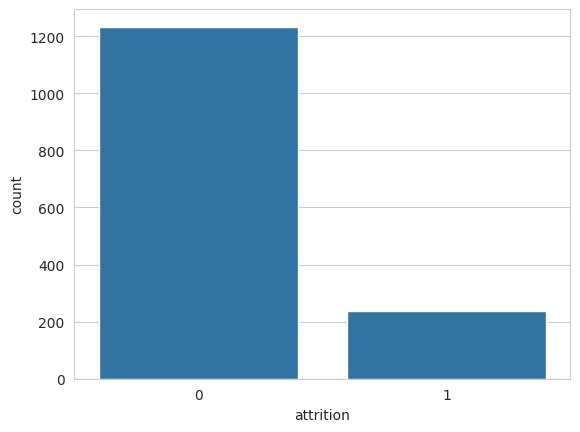

In [7]:
sns.countplot(data=df, x="attrition")
plt.show()

In [8]:
X.describe()

,age,distance from home (miles),monthly income,number of companies worked,years at company
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,9.192517,6502.931293,2.693197,7.008163
std,9.135373,8.106864,4707.956783,2.498009,6.126525
min,18.000000,1.000000,1009.000000,0.000000,0.000000
25%,30.000000,2.000000,2911.000000,1.000000,3.000000
50%,36.000000,7.000000,4919.000000,2.000000,5.000000
75%,43.000000,14.000000,8379.000000,4.000000,9.000000
max,60.000000,29.000000,19999.000000,9.000000,40.000000


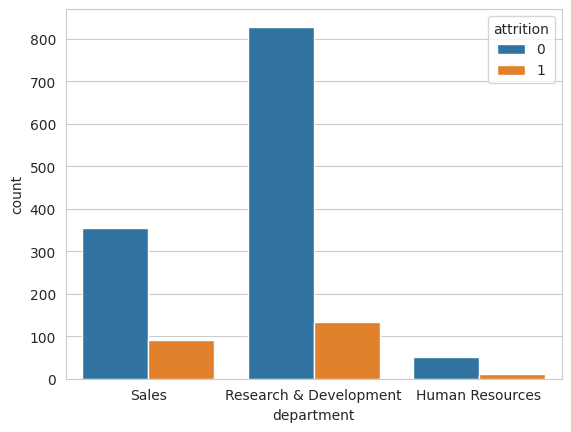

In [9]:
sns.countplot(data=df, x="department", hue="attrition")
plt.show()

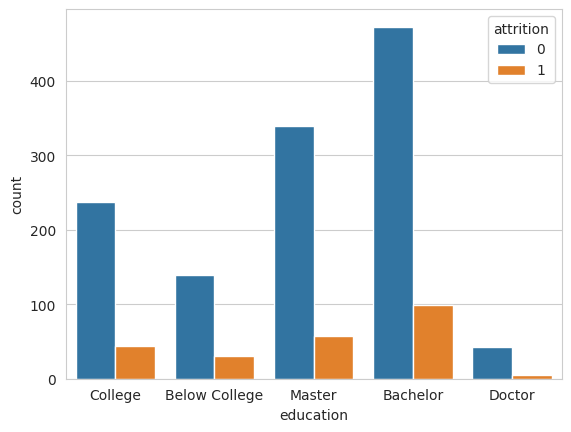

In [10]:
sns.countplot(data=df, x="education", hue="attrition")
plt.show()

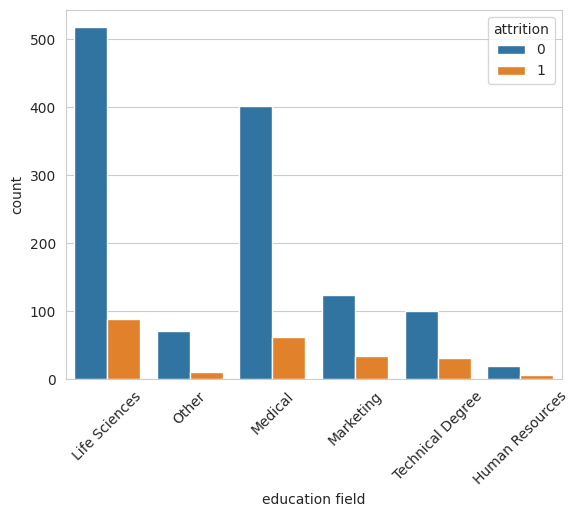

In [11]:
sns.countplot(data=df, x="education field", hue="attrition")
plt.xticks(rotation=45)
plt.show()

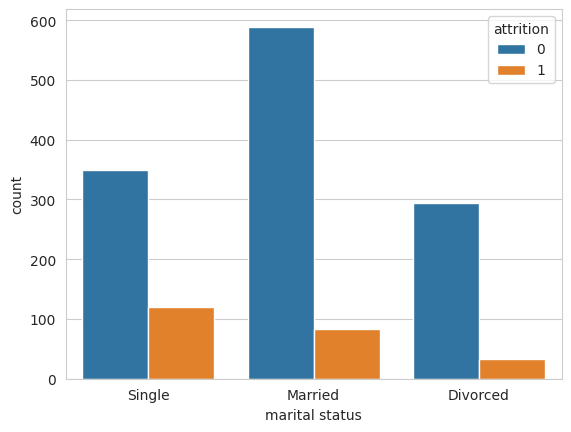

In [12]:
sns.countplot(data=df, x="marital status", hue="attrition")
plt.show()

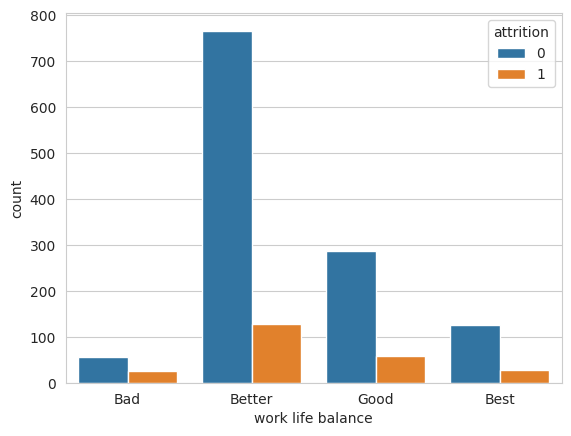

In [13]:
sns.countplot(data=df, x="work life balance", hue="attrition")
plt.show()

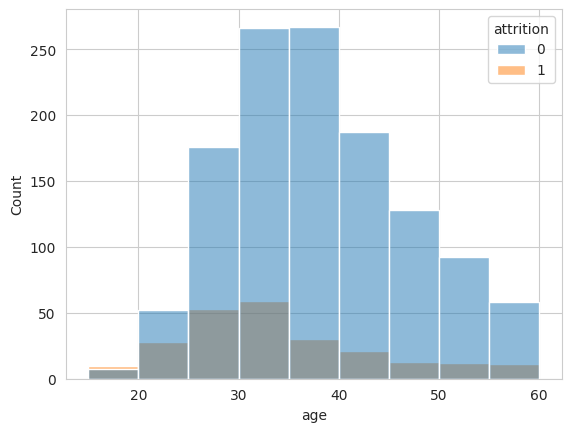

In [14]:
sns.histplot(data=df, x="age", hue="attrition", bins=list(range(15, 61, 5)))
plt.show()

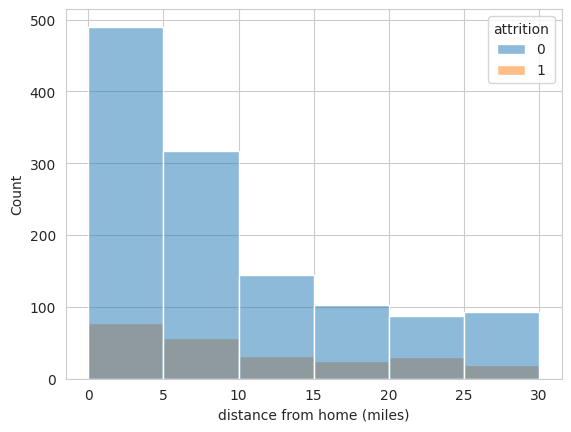

In [15]:
sns.histplot(data=df, x="distance from home (miles)", hue="attrition", bins=range(0, 31, 5))
plt.show()

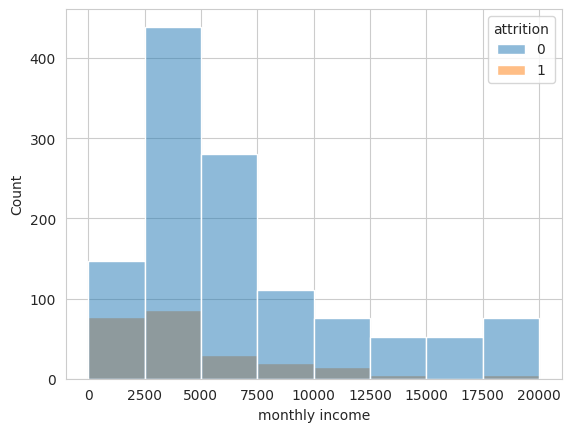

In [16]:
sns.histplot(data=df, x="monthly income", hue="attrition", bins=range(0, 20001, 2500))
plt.show()

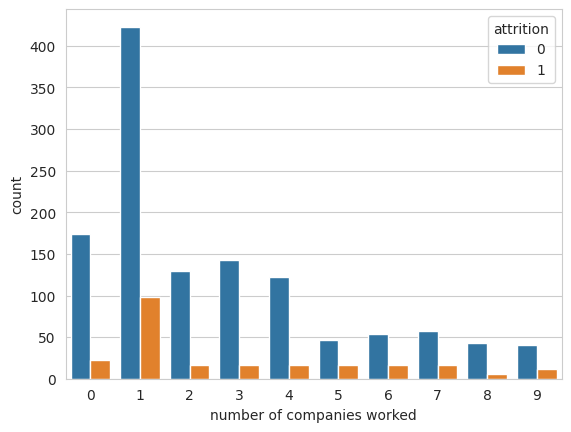

In [17]:
sns.countplot(data=df, x="number of companies worked", hue="attrition")
plt.show()

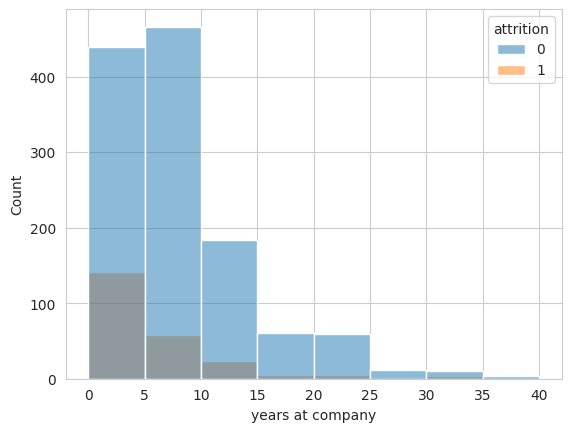

In [18]:
sns.histplot(data=df, x="years at company", hue="attrition", bins=range(0, 41, 5))
plt.show()

In [19]:
for col in numeric:
    corr, p = pointbiserialr(df[col], y)
    print(f"The Point-biserial correlation between '{col}' and the target is {corr:.3f}, with a p-value of {p:.3e}")

The Point-biserial correlation between 'age' and the target is -0.159, with a p-value of 8.356e-10
The Point-biserial correlation between 'distance from home (miles)' and the target is 0.078, with a p-value of 2.793e-03
The Point-biserial correlation between 'monthly income' and the target is -0.160, with a p-value of 7.147e-10
The Point-biserial correlation between 'number of companies worked' and the target is 0.043, with a p-value of 9.553e-02
The Point-biserial correlation between 'years at company' and the target is -0.134, with a p-value of 2.319e-07


In [20]:
for col in category:
    mutual_info = mutual_info_score(df[col], y)
    print(f"The mutual information between '{col}' and the target is {mutual_info:.3f}")

The mutual information between 'department' and the target is 0.004
The mutual information between 'education' and the target is 0.001
The mutual information between 'education field' and the target is 0.005
The mutual information between 'marital status' and the target is 0.015
The mutual information between 'work life balance' and the target is 0.005


## Feature Engineering + Model Training & Hyperparameter Tuning

### Logistic Regression

In [21]:
clf = CalibratedClassifierCV(estimator=LogisticRegression(max_iter=1000, random_state=SEED, n_jobs=-1), cv=FOLDS, n_jobs=-1)
logistic_pipeline = Pipeline(
    [("encoder", ce.WOEEncoder(cols=category)),
     ("scaler", StandardScaler()),
     ("classifier", clf)]
)

logistic_param_grid = {
    "classifier__estimator__C": [0.1, 1, 10, 100],
    "classifier__estimator__class_weight": [None, "balanced"],
    "classifier__method": ["sigmoid", "isotonic"]
}

In [22]:
logistic_grid_search = GridSearchCV(logistic_pipeline, logistic_param_grid, scoring="neg_log_loss", cv=FOLDS)
logistic_grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encoder',
                                        WOEEncoder(cols=['department',
                                                         'education',
                                                         'education field',
                                                         'marital status',
                                                         'work life balance'])),
                                       ('scaler', StandardScaler()),
                                       ('classifier',
                                        CalibratedClassifierCV(cv=5,
                                                               estimator=LogisticRegression(max_iter=1000,
                                                                                            n_jobs=-1,
                                                                                            random_state=42),
                                                               n_jobs=-1))]),
             param_grid={'classifier__estimator__C': [0.1, 1, 10, 100],
                         'classifier__estimator__class_weight': [None,
                                                                 'balanced'],
                         'classifier__method': ['sigmoid', 'isotonic']},
             scoring='neg_log_loss')

In [23]:
print("Best hyperparameters: ", logistic_grid_search.best_params_)
print("Best negative log loss: ", logistic_grid_search.best_score_)

Best hyperparameters:  {'classifier__estimator__C': 0.1, 'classifier__estimator__class_weight': None, 'classifier__method': 'sigmoid'}
Best negative log loss:  -0.3977514098055999


### Random Forest

In [24]:
clf = CalibratedClassifierCV(estimator=RandomForestClassifier(random_state=SEED, n_jobs=-1), cv=FOLDS, n_jobs=-1)
rf_pipeline = Pipeline(
    [("encoder", ce.WOEEncoder(cols=category)),
     ("classifier", clf)]
)

rf_param_grid = {
    "classifier__estimator__n_estimators": [20, 50, 100],
    "classifier__estimator__max_depth": [10, 15, 20],
    "classifier__estimator__min_samples_leaf": [0.01, 0.02, 0.05],
    "classifier__estimator__min_samples_split": [0.01, 0.02, 0.05],
    "classifier__estimator__class_weight": [None, "balanced"],
    "classifier__method": ["sigmoid", "isotonic"]
}

In [25]:
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, scoring="neg_log_loss", cv=FOLDS)
rf_grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encoder',
                                        WOEEncoder(cols=['department',
                                                         'education',
                                                         'education field',
                                                         'marital status',
                                                         'work life balance'])),
                                       ('classifier',
                                        CalibratedClassifierCV(cv=5,
                                                               estimator=RandomForestClassifier(n_jobs=-1,
                                                                                                random_state=42),
                                                               n_jobs=-1))]),
             param_grid={'classifier__estimator__class_weight': [None,
                                                                 'balanced'],
                         'classifier__estimator__max_depth': [10, 15, 20],
                         'classifier__estimator__min_samples_leaf': [0.01, 0.02,
                                                                     0.05],
                         'classifier__estimator__min_samples_split': [0.01,
                                                                      0.02,
                                                                      0.05],
                         'classifier__estimator__n_estimators': [20, 50, 100],
                         'classifier__method': ['sigmoid', 'isotonic']},
             scoring='neg_log_loss')

In [26]:
print("Best hyperparameters: ", rf_grid_search.best_params_)
print("Best negative log loss: ", rf_grid_search.best_score_)

Best hyperparameters:  {'classifier__estimator__class_weight': None, 'classifier__estimator__max_depth': 15, 'classifier__estimator__min_samples_leaf': 0.02, 'classifier__estimator__min_samples_split': 0.05, 'classifier__estimator__n_estimators': 20, 'classifier__method': 'sigmoid'}
Best negative log loss:  -0.39017360659990946


### XGBoost

In [27]:
clf = CalibratedClassifierCV(estimator=XGBClassifier(objective="binary:logistic", random_state=SEED, n_jobs=-1), cv=FOLDS, n_jobs=-1)
xgb_pipeline = Pipeline(
    [("encoder", ce.TargetEncoder(cols=category)),
     ("classifier", clf)]
)

xgb_param_grid = {
    "classifier__estimator__learning_rate": [0.5, 0.3, 0.1],
    "classifier__estimator__n_estimators": [20, 50, 100, 200],
    "classifier__estimator__max_depth": [4, 6],
    "classifier__estimator__min_child_weight": [1, 2],
    "classifier__estimator__max_delta_step": [1, 2, 5, 10],
    "classifier__method": ["sigmoid", "isotonic"]
}

In [28]:
xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, scoring="neg_log_loss", cv=FOLDS)
xgb_grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encoder',
                                        TargetEncoder(cols=['department',
                                                            'education',
                                                            'education field',
                                                            'marital status',
                                                            'work life '
                                                            'balance'])),
                                       ('classifier',
                                        CalibratedClassifierCV(cv=5,
                                                               estimator=XGBClassifier(base_score=None,
                                                                                       booster=None,
                                                                                       callbacks=None,
                                                                                       colsample_bylevel=None,
                                                                                       colsample_bynode=None,
                                                                                       colsample_bytree=None,
                                                                                       device=None,
                                                                                       early...
                                                                                       random_state=42, ...),
                                                               n_jobs=-1))]),
             param_grid={'classifier__estimator__learning_rate': [0.5, 0.3,
                                                                  0.1],
                         'classifier__estimator__max_delta_step': [1, 2, 5, 10],
                         'classifier__estimator__max_depth': [4, 6],
                         'classifier__estimator__min_child_weight': [1, 2],
                         'classifier__estimator__n_estimators': [20, 50, 100,
                                                                 200],
                         'classifier__method': ['sigmoid', 'isotonic']},
             scoring='neg_log_loss')

In [29]:
print("Best hyperparameters: ", xgb_grid_search.best_params_)
print("Best negative log loss: ", xgb_grid_search.best_score_)

Best hyperparameters:  {'classifier__estimator__learning_rate': 0.1, 'classifier__estimator__max_delta_step': 5, 'classifier__estimator__max_depth': 4, 'classifier__estimator__min_child_weight': 1, 'classifier__estimator__n_estimators': 50, 'classifier__method': 'isotonic'}
Best negative log loss:  -0.39449880287544953


### Save Column Attributes

In [30]:
col_attr = {}
for col in X.columns:
    if col in category:
        col_attr[col] = ("category", list(X[col].unique()))
    else:
        if "int" in str(X.dtypes[col]):
            col_attr[col] = ("numeric", "int")
        else:
            col_attr[col] = ("numeric", "float")

with open("columns_attribute.json", "w") as f_out:
    json.dump(col_attr, f_out, indent=4)